In [ ]:
# Packages Exercice 1
from functools import reduce
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

In [ ]:
# Packages Exercice 2
import re
import urllib.request, re
from bs4 import BeautifulSoup

In [1]:
# Packages Exercice 3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from skimpy import skim
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import category_encoders as ce
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import sagemaker
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.sklearn.model import SKLearnModel
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import CSVDeserializer
import Train_sm
import  boto3, os

c:\Users\donag\Documents\Projets M2 TIDE\.ptide\Lib\site-packages\pydantic\_internal\_fields.py:198: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[04/25/25 16:52:17] INFO     Found credentials in shared credentials file: ~/.aws/credentials   credentials.py:1352

sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\donag\AppData\Local\sagemaker\sagemaker\config.yaml


In [2]:
warnings.filterwarnings("ignore")

# **Exercice 1**

On souhaite afficher pour les utilisateurs d’un réseau social le nombre d’amis en commun avec un autre utilisateur quand il visite la page de ce dernier.

1. Ecrivez sous python, un programme de type MapReduce qui calcule le nombre d’amis en communs pour chaque paire d’utilisateurs sachant que le fichier amis.txt contient les identifiants des utilisateurs suivis des identifiants de leurs amis.

2. Ré-écrirez votre programme MapReduce en utilisant Pyspark.

NB : Un programme de type MapReduce comprend deux phases : une phase de map où vous auriez en sortie des données sous forme clé-valeur, et une phase d’aggrégation. Vous pouvez vous inspirer des indications en fin de chapitre 2.

### *Lecture du fichier*

In [ ]:
# Importation de la table amis.txt. Au vu de la construction de la table nous allon sl'importer sous forme de disctionnaire :
# Pour ce faire on va lire le fichier ligne par ligne
dico = {}
with open("../Data/amis.txt", 'r') as f: # On ouvre le fichier pour le lire 
    next(f)  # On ne lis pas la prmière ligne car contient le nom des variables et cela ne nous interesse pas.
    for ligne in f: # On lit ensuite le fichier ligne par ligne
        ligne = ligne.strip() # On retire tous les espaces pour avoir tout à la suite
        utilisateur, amis_str = ligne.split(":") # Ce qui est a gaughe des ":" est l'utilisateur et ce qui est à droite est la liste de ses amis
        utilisateur = int(utilisateur.strip()) # On met en int et non en object "" 
        amis = set(map(int, amis_str.split(","))) # Il nous retse necore a séparer les amis par "," 
        dico[utilisateur] = amis




In [ ]:
dico

{10: {20, 30, 40},
 20: {10, 30, 40},
 30: {10, 20, 40, 50},
 40: {10, 20, 30, 50},
 50: {30, 40}}

### *Question 1 :*

In [ ]:
def map_cree(dico):
    """ 
    Fonction qui génère une liste de paires (utilisateur, ami) à partir d'un dictionnaire où chaque utilisateur 
    est associé à une liste d'amis. Chaque paire (utilisateur, ami) est ensuite associée à la liste complète des 
    amis de l'utilisateur. 
    ATTENTION :  les paires sont triées (min, max)pour éviter les doublons .

    """
    list_map = []

    for utilisateur, liste_amis in dico.items(): # On parcout le dictionnaire
        for ami in liste_amis: # On parcourt la liste d'amis de l'utilisateur (chaque utilisateur sera en paire avec chaque ami de sa liste d'amis)
            paire = tuple(sorted((utilisateur, ami)))# on ordonne notre paire pour éviter les redondances
            list_map.append((paire, dico[utilisateur])) # On ajoute a notre en entrée la paire et la liste d'amis de l'utilisateur

    return list_map

In [ ]:
list_map = map_cree(dico)
list_map

[((10, 40), {20, 30, 40}),
 ((10, 20), {20, 30, 40}),
 ((10, 30), {20, 30, 40}),
 ((20, 40), {10, 30, 40}),
 ((10, 20), {10, 30, 40}),
 ((20, 30), {10, 30, 40}),
 ((30, 40), {10, 20, 40, 50}),
 ((10, 30), {10, 20, 40, 50}),
 ((20, 30), {10, 20, 40, 50}),
 ((30, 50), {10, 20, 40, 50}),
 ((10, 40), {10, 20, 30, 50}),
 ((20, 40), {10, 20, 30, 50}),
 ((40, 50), {10, 20, 30, 50}),
 ((30, 40), {10, 20, 30, 50}),
 ((40, 50), {30, 40}),
 ((30, 50), {30, 40})]

À présent il nous suffit de regrouper les paires identiques et compter le nombre d'amis en commun. (étape reduce)

Pour ce faire, on groupe par paire, puis pour les groupements fait on va regarder les intersections de la liste d'amis de l'utilisateur et compter combien on a d'amis en commun.

In [ ]:
# Utilisation des fonctions vues en TP :
def groupByKey(data):
    """ data est une liste"""
    result = dict()
    for (key, value) in data:
        if key in result:
            result[key].append(value)
        else:
            result[key] = [value]
    return result

def reduceByKey(f, data):
    key_values = groupByKey(data)
    return map(lambda key: (key, reduce(f, key_values[key])), key_values)


In [ ]:
def intersec(set1, set2):
    """Renvoie l'intersection de deux sets"""
    return set1.intersection(set2)

In [ ]:
reduce_cree = reduceByKey(intersec, list_map)

for paire, communs in reduce_cree:
    print(f"La paire {paire} a {len(communs)} amis en commun")


La paire (10, 40) a 2 amis en commun
La paire (10, 20) a 2 amis en commun
La paire (10, 30) a 2 amis en commun
La paire (20, 40) a 2 amis en commun
La paire (20, 30) a 2 amis en commun
La paire (30, 40) a 3 amis en commun
La paire (30, 50) a 1 amis en commun
La paire (40, 50) a 1 amis en commun


### *Question 2 :*

In [ ]:
# Initialiser SparkContext : obligatoire de créer 
spark = SparkSession.builder.appName("amis").getOrCreate()
sc = spark.sparkContext


25/04/12 18:05:20 WARN Utils: Your hostname, MacBook-Pro-de-Melanie.local resolves to a loopback address: 127.0.0.1; using 192.168.1.53 instead (on interface en0)
25/04/12 18:05:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/12 18:05:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 50422)
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/socketserver.py", line 318, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/socketserver.py", line 349, in process_request
    self.finish_request(request, client_address)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/socketserver.py", line 362, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/socketserver.py", line 761, in __init__
    self.handle()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/Library/Frameworks/Pyt

In [ ]:
# Conversion de notre dictionnaire contenant les informations de amis.txt (dico) en RDD pour Spark
dico_rdd = sc.parallelize(dico.items())


In [ ]:
def map_cree_spark(ami_entry):
    """ 
    Memme principe que la fonction map_cree mais pour Spark.    
    Cette fonction prend une entrée sous forme de tuple (utilisateur, amis) et crée une 
    liste de paires (utilisateur, ami) où chaque ami est lié à l'utilisateur. 
    """
    utilisateur, amis = ami_entry
    result = []
    for ami in amis:
        paire = tuple(sorted((utilisateur, ami)))  
        result.append((paire, amis))  
    return result


In [ ]:
map_spark = dico_rdd.flatMap(map_cree_spark)

Cette fonction intersec_spark est une manière efficace de calculer l'intersection de plusieurs sets dans un contexte de parallélisation avec PySpark. Elle s'assure que l'intersection se fait progressivement entre deux sets à la fois, ce qui est nécessaire lorsque les données sont distribuées et traitées de manière parallèle.

In [ ]:
def intersec_spark(amis_lists):
    """
    Calcul des intersections de plusieurs sets (nécessaire avec la parallélisation de PySpark). 
    Cette fonction suit le même principe que la fonction `intersec`, mais elle permet de traiter 
    plusieurs sets (plutôt que seulement deux) en appliquant l'intersection successivement 
    sur chaque paire de sets dans la liste. 
    """
    result = amis_lists[0] # on initialise avec le premier set
    for amis_set in amis_lists[1:]: # on parcourt les autres sets
        result = intersec(result, amis_set)  # on appliue la fonction intersec poour le set1 avec tous les autres sets
    return result


In [ ]:
result_rdd = map_spark.groupByKey().mapValues(lambda amis_lists: intersec_spark(list(amis_lists)))# utilisation de reduceByKey pour calculer l'intersection des amis

result = result_rdd.collect() # pour colocter les résultats des RDD
result

[((30, 50), {40}),
 ((40, 50), {30}),
 ((10, 40), {20, 30}),
 ((10, 20), {30, 40}),
 ((20, 40), {10, 30}),
 ((30, 40), {10, 20, 50}),
 ((10, 30), {20, 40}),
 ((20, 30), {10, 40})]

In [ ]:
for paire, communs in result:
    print(f"La paire {paire} a {len(communs)} amis en commun")


La paire (30, 50) a 1 amis en commun
La paire (40, 50) a 1 amis en commun
La paire (10, 40) a 2 amis en commun
La paire (10, 20) a 2 amis en commun
La paire (20, 40) a 2 amis en commun
La paire (30, 40) a 3 amis en commun
La paire (10, 30) a 2 amis en commun
La paire (20, 30) a 2 amis en commun


# **Exercice 2**

In [ ]:
def openLink(i): 
    '''
    Entrée : Lien d'un site web. 
    Fonctionnalité : On lit le lien et on extrait le texte. 

    Notes : Pour l'instant cela marche que pour les sites web dont le titre rentre en UTF-8
    '''
    Site = urllib.request.urlopen(i)
    Content = Site.read()
    Site.close
    parsedWeb = BeautifulSoup(Content, "html.parser")
    textWeb = parsedWeb.get_text()
    return textWeb

In [ ]:
# Fonction permettant de mettre le texte dans le format pour réaliser un WordCount
def wordTransform(data): 
    '''
    Entrée : Texte extrait du site web. 
    Fonctionnalité : On extrait les mots dans une liste en suivant les indication de compilation. 
                     A chaque mot on ajouté un chiffre 1 qui indique son apparition. 
                     Le regex d'une longeur de 3 nous permet d'enlever la plupart d'articles et 
                     garder plus de mots qui peuvent avoir un vrai sens.
    '''
    # patternText =  re.compile(r"[a-zA-Z]\w{4,}")
    patternText =  re.compile(r"[A-Za-zÀ-ÖØ-öœŒÇç]+\w{4,}")
    wordsTransformed = patternText.findall(data)
    mapTexte= map(lambda x: (x,1), wordsTransformed)
    mapTexte=list(mapTexte)
    return mapTexte

In [ ]:
# Fonction permettant de garder le nombre d'apparitions d'un mot en format 1
def groupByKey(data):
    ''' 
    Entrée : Liste de mots et chiffre
    Fonctionnalité : On groupe les chiffres selon les clés, ici, des mots. 
    '''
    result = dict()
    for key, value in data:
        if key in result:
            result[key].append(value)
        else:
            result[key] = [value]
    return result

In [ ]:
# Fonction permettant de voir le nombre d'apparitions d'un mot. 
def reduceByKey(f, data):
    ''' 
    Entrée : Une fonction et la liste de mots et index.
    Fonctionnalité : On groupe les chiffres par les mots. Puis on additione les
                     elements afin d'avoir le nombre d'apparitions.
    '''
    key_values = groupByKey(data)
    return map(lambda key: (key, reduce(f, key_values[key])),key_values)

In [ ]:
def kmaxSelect(data , k):
    '''
    Entrée : Liste avec nombre d'apparition des mots. 
    Fonctionnalité : On tri la liste et on extrait les K elements plus présents. 
    '''
    wordDict = dict(data)
    sortedWordDict = sorted(wordDict.items() , key = lambda x:x[1])
    keyWords = sortedWordDict[-k:]
    return keyWords

In [ ]:
# Exportation des resultats. 
def expResult(data): 
    ''' 
    Entrée : On rentre notre dictionnaire contennant le lien en tant que clé 
             et la liste des mots fréquents en tant que valeur. 
    Fonctionnalité :On exporte ici les resultats obtenus précedémment. 
                    Cela est en dehors de la fonction principale afin que
                    cela ne soit pas systematiquement fait mais uniquement 
                    quand l'utilisateur aura besoin. 
    '''
    document = open("webMostWords.txt",'w')
    for i in data.keys(): 
        document.write(f'Pour le site {i}, les mot(s) plus fréquents sont : \n {(data[i])}\n\n')
    document.write("NB : Ces mots sont organisées en ordre croissant en nombre d'apparitions ")
    document.close()
    return

In [ ]:
def webMax (data,k): 
    ''' 
    Entrée : Liste de liens et quantité des mots plus fréquents qu'on attend en retour. 
    Fonctionnalité : Lien par lien, nous utiliserons décrites précedémment. A la fin nous 
                    gardons que les clés et non pas les fréquences en tenant compte de K.
    '''
    topWords = dict()
    for i in data : 
        textWeb = openLink(i)
        mapText = wordTransform(textWeb)
        wordDict = list(reduceByKey(lambda x, y: x + y, mapText))
        wordDict = dict(wordDict)
        sortedWordDict = sorted(wordDict.items() , key = lambda x:x[1])
        keyWords = dict(sortedWordDict[-k:])
        topWords[i] = list(keyWords.keys())
    print(f"{topWords}")
    expResult(topWords)
    return 

In [ ]:
# Création des liste des liens afin de tester notre fonction. 
i = "https://fr.wikipedia.org/wiki/Formule_1"
j = "https://fr.wikipedia.org/wiki/Paris"
k = "https://es.wikipedia.org/wiki/Machu_Picchu"
m = "https://www.francetvinfo.fr/sante/deserts-medicaux/le-gouvernement-veut-imposer-jusqu-a-deux-jours-par-mois-aux-medecins-dans-les-deserts-medicaux-dans-le-cadre-du-pacte-de-lutte-annonce-par-francois-bayrou_7210275.html" 

liens = (i,j,k,m)

In [ ]:
# Utilisation et Output de notre fonction. 
webMax(liens,10)

{'https://fr.wikipedia.org/wiki/Listes_des_communes_de_France': ['modifier', 'Insee', 'consulté', 'Région', 'Total', 'Haute', 'Loire', 'France', 'Années', 'communes'], 'https://it.wikipedia.org/wiki/Colombia': ['nella', 'originale', 'maggio', 'wikitesto', 'delle', 'archiviato', 'consultato', 'modifica', 'della', 'Colombia'], 'https://fr.wikipedia.org/wiki/Sorbonne': ['Centre', 'collège', 'sciences', 'université', 'Richelieu', 'étudiants', 'modifier', 'Institut', 'Paris', 'Sorbonne'], 'https://es.wikipedia.org/wiki/Fuerza_Aeroespacial_Colombiana': ['Militar', 'editar', 'Escuadrón', 'Consultado', 'Aéreo', 'Colombia', 'Combate', 'Colombiana', 'Fuerza', 'Aérea']}


# **Exercice 3**

In [3]:
# Import des données
df = pd.read_csv("../Data/tab_credit.csv", sep=",")

### *1. Analyse exploratoire*

In [ ]:
df.shape

(5961, 13)

In [ ]:
df.head()

,bad,loan,mortdue,value,reason,job,yoj,derog,delinq,clage,ninq,clno,debtinc
0,1.0,1100.0,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.37,1.0,9.0,NaN
1,1.0,1300.0,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.83,0.0,14.0,NaN
2,1.0,1500.0,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.47,1.0,10.0,NaN
3,1.0,1500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,1700.0,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.33,0.0,14.0,NaN


In [ ]:
df.dtypes

bad        float64
loan       float64
mortdue    float64
value      float64
reason      object
job         object
yoj        float64
derog      float64
delinq     float64
clage      float64
ninq       float64
clno       float64
debtinc    float64
dtype: object

In [ ]:
# Description Variables catégorielles
skim(df.select_dtypes(include="object"))

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 5961   │ │ string      │ 2     │                                                          │
│ │ Number of columns │ 2      │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     string                                                      │
│ ┏━━━━━━━━┳━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┓  │
│ ┃        ┃     ┃            ┃          ┃         ┃         ┃         ┃ chars per  ┃ words per   ┃ total      ┃  │
│ ┃ column ┃ NA  ┃ NA %       ┃ shortest ┃ longest ┃ min     ┃ max     ┃ row        ┃ row         ┃ words      ┃  │
│ ┡━━━━━━━━╇━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━┩  │
│ │ reason │ 252 │ 4.22747861 │ HomeImp  │ HomeImp │ DebtCon │ HomeImp │          7 │        0.96 │       5709 │  │
│ │        │     │    0971313 │          │         │         │         │            │             │            │  │
│ │ job    │ 279 │ 4.68042274 │ Mgr      │ Office  │ Mgr     │ Self    │       5.09 │        0.95 │       5682 │  │
│ │        │     │    7861097 │          │         │         │         │            │             │            │  │
│ └────────┴─────┴────────────┴──────────┴─────────┴─────────┴─────────┴────────────┴─────────────┴────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [ ]:
# Description Variables numériques
skim(df.select_dtypes(include="float64"))

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 5961   │ │ float64     │ 11    │                                                          │
│ │ Number of columns │ 11     │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     number                                                      │
│ ┏━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column   ┃ NA    ┃ NA %               ┃ mean   ┃ sd     ┃ p0    ┃ p25   ┃ p50   ┃ p75    ┃ p100   ┃ hist   ┃  │
│ ┡━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━┩  │
│ │ bad      │     0 │                  0 │ 0.1995 │ 0.3996 │     0 │     0 │     0 │      0 │      1 │ ▇    ▂ │  │
│ │ loan     │     0 │                  0 │  18620 │  11240 │  1100 │ 11100 │ 16300 │  23300 │  89900 │  ▇▇▁   │  │
│ │ mortdue  │   518 │  8.689817144774366 │  73760 │  44450 │  2063 │ 46280 │ 65020 │  91480 │ 399600 │  ▇▆▁   │  │
│ │ value    │   112 │ 1.8788793826539172 │ 101800 │  57380 │  8000 │ 66080 │ 89230 │ 119800 │ 855900 │   ▇▁   │  │
│ │ yoj      │   515 │   8.63949001845328 │  8.923 │  7.574 │     0 │     3 │     7 │     13 │     41 │  ▇▅▂▁  │  │
│ │ derog    │   708 │ 11.877201811776548 │ 0.2545 │  0.846 │     0 │     0 │     0 │      0 │     10 │   ▇    │  │
│ │ delinq   │   580 │    9.7299110887435 │ 0.4494 │  1.127 │     0 │     0 │     0 │      0 │     15 │   ▇    │  │
│ │ clage    │   308 │ 5.1669183022982725 │  179.8 │   85.8 │     0 │ 115.1 │ 173.5 │  231.6 │   1168 │   ▇▅   │  │
│ │ ninq     │   510 │    8.5556114745848 │  1.186 │  1.729 │     0 │     0 │     1 │      2 │     17 │   ▇▁   │  │
│ │ clno     │   222 │  3.724207347760443 │   21.3 │  10.14 │     0 │    15 │    20 │     26 │     71 │  ▂▇▅▁  │  │
│ │ debtinc  │  1267 │ 21.254823016272436 │  33.78 │  8.601 │ 0.524 │ 29.14 │ 34.82 │     39 │  203.3 │   ▇▇   │  │
│ └──────────┴───────┴────────────────────┴────────┴────────┴───────┴───────┴───────┴────────┴────────┴────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [ ]:
# Nombre de modalités pour chaque variables catégorielles
for i in ["bad","reason","job"]:
    print(f"Nombre de modalité pour la variable:")
    print(df[i].value_counts(dropna=False))
    print("\n")

Nombre de modalité pour la variable:
bad
0.0    4772
1.0    1189
Name: count, dtype: int64


Nombre de modalité pour la variable:
reason
DebtCon    3929
HomeImp    1780
NaN         252
Name: count, dtype: int64


Nombre de modalité pour la variable:
job
Other     2389
ProfEx    1276
Office     948
Mgr        767
NaN        279
Self       193
Sales      109
Name: count, dtype: int64




In [ ]:
# Préparation dataframe avec variables numériques
df_num = df.select_dtypes(include="float64")
df_num.drop(columns=["bad"],inplace=True)

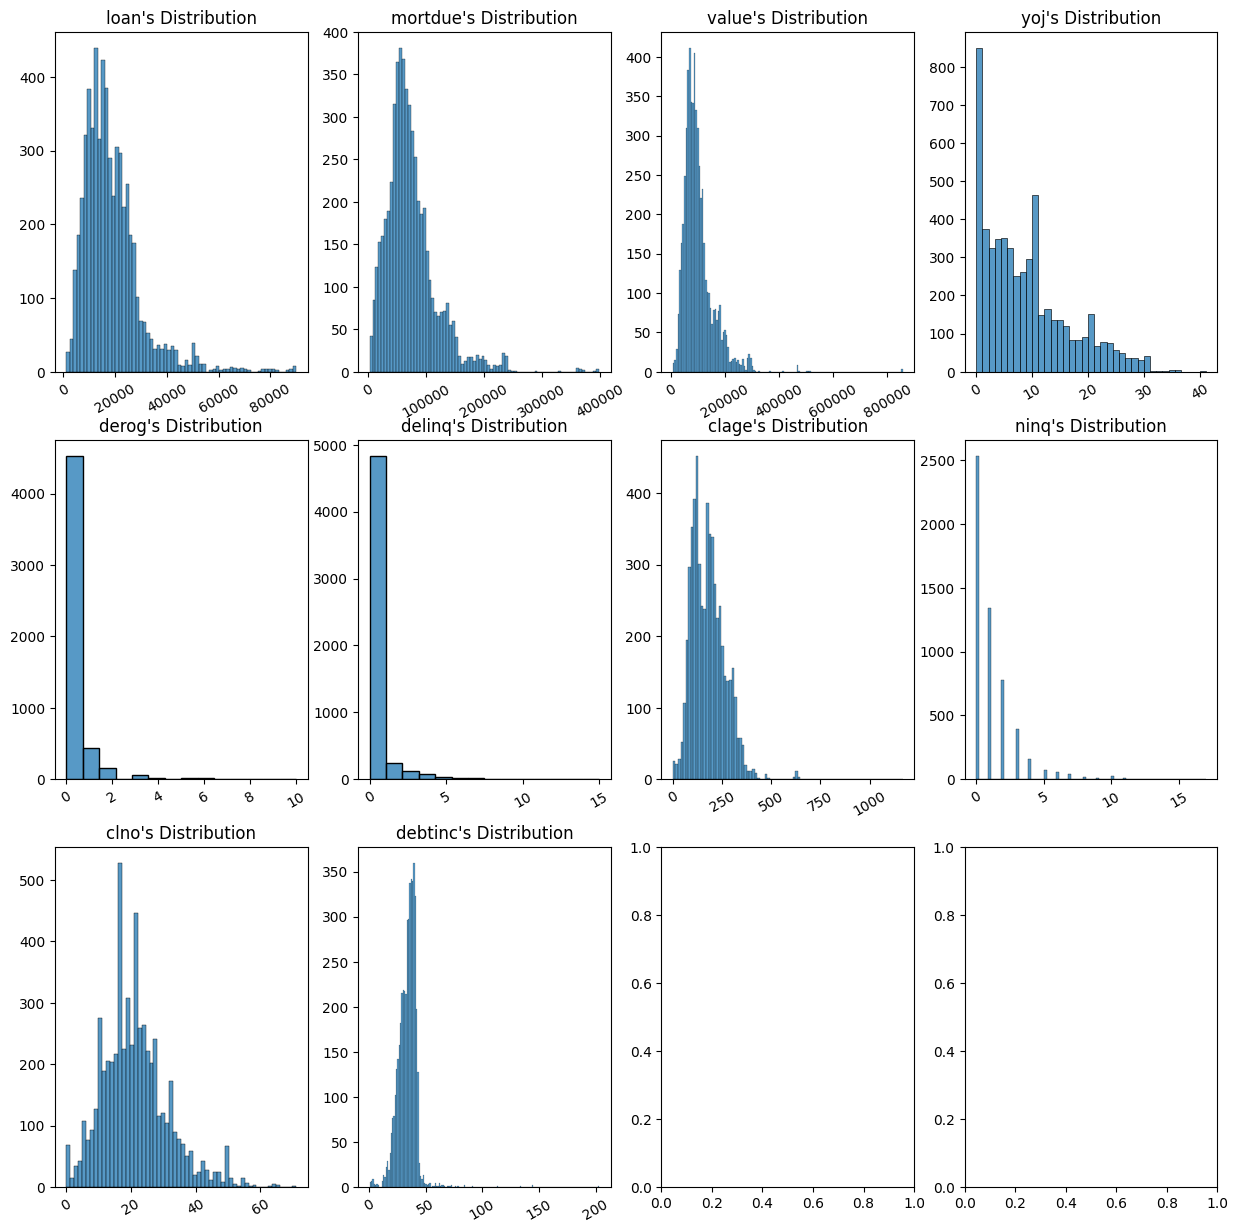

In [ ]:
# Histogrammes
i,j = 0,0
fig, axs = plt.subplots(3,4,figsize=(15,15))
for col in df_num.columns:
    sns.histplot(data=df_num[col],ax=axs[i][j])
    axs[i][j].set_xticklabels(axs[i][j].get_xticklabels(),rotation=30)
    axs[i][j].set_xlabel(None)
    axs[i][j].set_ylabel(None)
    axs[i][j].set_title(f"{col}'s Distribution")
    j+=1
    if j%4 == 0:
        i+=1
        j=0

On remarque qu'on dispose de variables avec des échelles différentes, en raison de leur nature (continues vs discrètes) ce qui est à retenir pour la suite

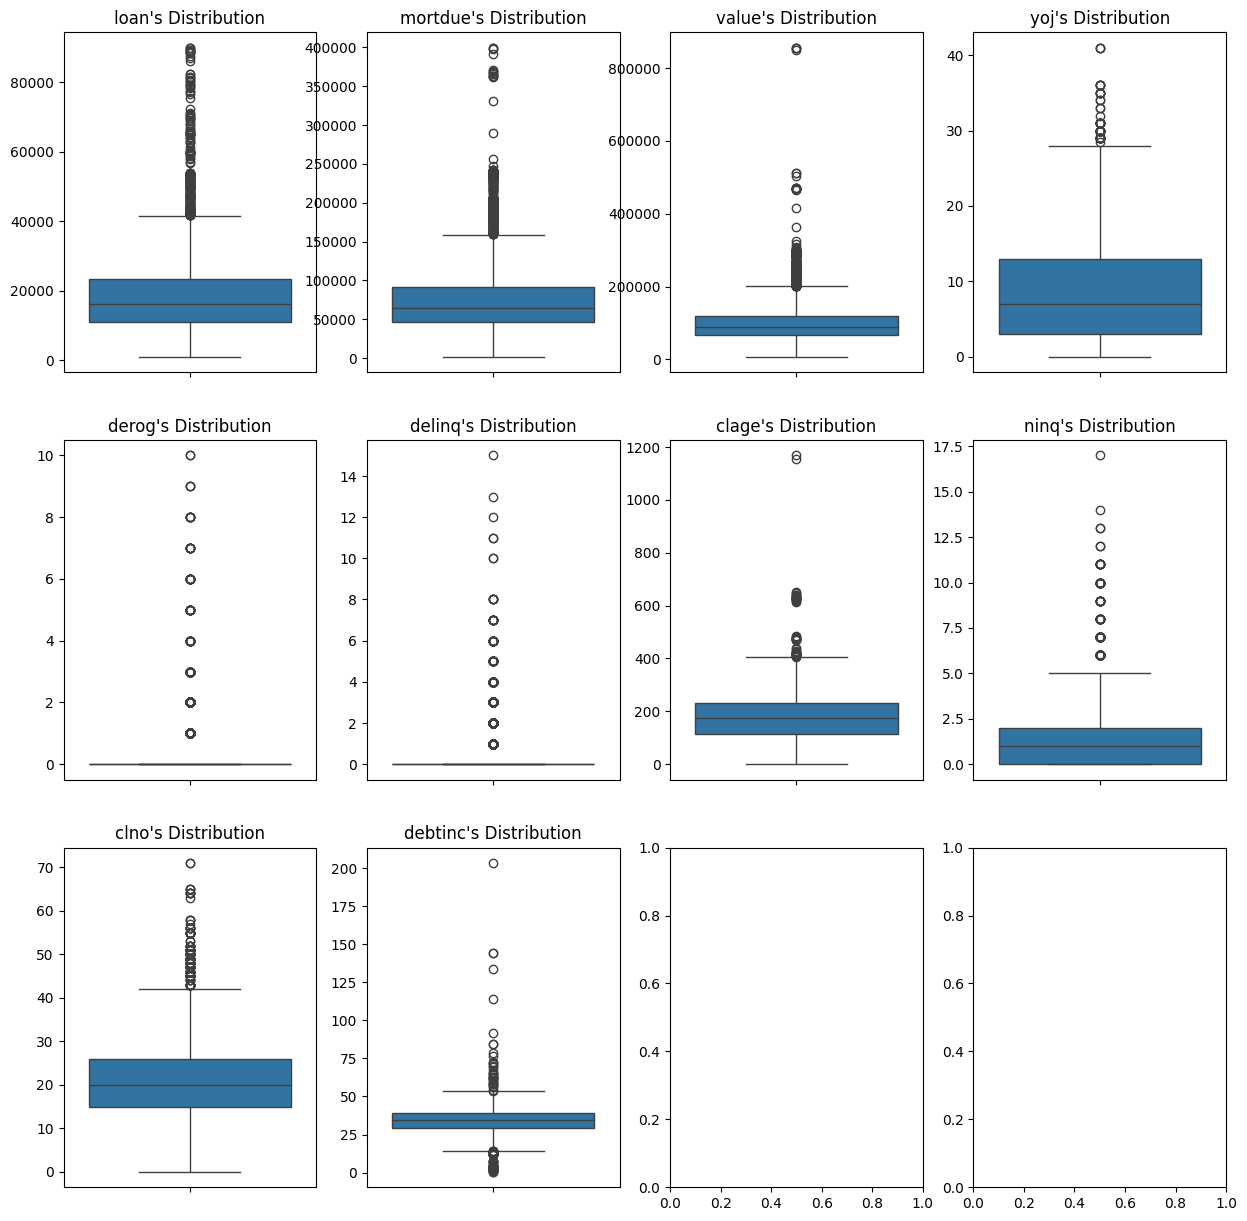

In [ ]:
# Boxplot
i,j = 0,0
fig, axs = plt.subplots(3,4,figsize=(15,15))
for col in df_num.columns:
    sns.boxplot(data=df_num[col],ax=axs[i][j])
    axs[i][j].set_xticklabels(axs[i][j].get_xticklabels(),rotation=30)
    axs[i][j].set_xlabel(None)
    axs[i][j].set_ylabel(None)
    axs[i][j].set_title(f"{col}'s Distribution")
    j+=1
    if j%4 == 0:
        i+=1
        j=0

Présence de beaucoup d'outliers en particulier pour les variables continues, ce qui n'est pas surprenant.

In [ ]:
# Doublons
df[df.duplicated()]

,bad,loan,mortdue,value,reason,job,yoj,derog,delinq,clage,ninq,clno,debtinc


In [ ]:
# Boxplots par classes à prédire
i,j = 1,1
fig = make_subplots(rows=3, cols=4, subplot_titles=[x for x in df_num.columns.tolist()])

for col in df_num.columns:
    fig.add_trace(
        go.Box(x=df["bad"],
               y=df[col]),
        row=i, col=j)
    j+=1
    if j%5==0:
        i+=1
        j=1

fig.update_layout(width=1500, height=1500,title_text="Boxplots d'interaction entre bad et les variables numériques",showlegend=False)  

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ c:\Users\donag\Documents\Projets M2 TIDE\.ptide\Lib\site-packages\IPython\core\formatters.py:282 │
│ in catch_format_error                                                                            │
│                                                                                                  │
│    279 def catch_format_error(method, self, *args, **kwargs):                                    │
│    280 │   """show traceback on failed format call"""                                            │
│    281 │   try:                                                                                  │
│ ❱  282 │   │   r = method(self, *args, **kwargs)                                                 │
│    283 │   except NotImplementedError:                                                           │
│    284 │   │   # don't warn on NotImplementedErrors                                              │
│    285 │   │   return self._check_return(None, args[0])                                          │
│                                                                                                  │
│ c:\Users\donag\Documents\Projets M2 TIDE\.ptide\Lib\site-packages\IPython\core\formatters.py:984 │
│ in __call__                                                                                      │
│                                                                                                  │
│    981 │   │   │   # Finally look for special method names                                       │
│    982 │   │   │   method = get_real_method(obj, self.print_method)                              │
│    983 │   │   │   if method is not None:                                                        │
│ ❱  984 │   │   │   │   method()                                                                  │
│    985 │   │   │   │   return True                                                               │
│    986                                                                                           │
│    987                                                                                           │
│                                                                                                  │
│ c:\Users\donag\Documents\Projets M2 TIDE\.ptide\Lib\site-packages\plotly\basedatatypes.py:833 in │
│ _ipython_display_                                                                                │
│                                                                                                  │
│    830 │   │   import plotly.io as pio                                                           │
│    831 │   │                                                                                     │
│    832 │   │   if pio.renderers.render_on_display and pio.renderers.default:                     │
│ ❱  833 │   │   │   pio.show(self)                                                                │
│    834 │   │   else:                                                                             │
│    835 │   │   │   print(repr(self))                                                             │
│    836                                                                                           │
│                                                                                                  │
│ c:\Users\donag\Documents\Projets M2 TIDE\.ptide\Lib\site-packages\plotly\io\_renderers.py:425 in │
│ show                                                                                             │
│                                                                                                  │
│   422 │   │   │   )                                                                              │
│   423 │   │                                                                                      │
│   424 │   │   if not nbformat or Version(nbformat.__version

Figure({
    'data': [{'type': 'box',
              'x': {'bdata': ('AAAAAAAA8D8AAAAAAADwPwAAAAAAAP' ... 'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA'),
                    'dtype': 'f8'},
              'xaxis': 'x',
              'y': {'bdata': ('AAAAAAAwkUAAAAAAAFCUQAAAAAAAcJ' ... 'AAAIDs9UAAAAAAwPL1QAAAAADA8vVA'),
                    'dtype': 'f8'},
              'yaxis': 'y'},
             {'type': 'box',
              'x': {'bdata': ('AAAAAAAA8D8AAAAAAADwPwAAAAAAAP' ... 'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA'),
                    'dtype': 'f8'},
              'xaxis': 'x2',
              'y': {'bdata': ('AAAAAABB2UAAAAAAUBrxQAAAAAAAXs' ... 'AAAECY6EAAAAAAYNXnQAAAAADgXuhA'),
                    'dtype': 'f8'},
              'yaxis': 'y2'},
             {'type': 'box',
              'x': {'bdata': ('AAAAAAAA8D8AAAAAAADwPwAAAAAAAP' ... 'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA'),
                    'dtype': 'f8'},
              'xaxis': 'x3',
              'y': {'bdata': ('AAAAACAO40AAAAAAALPwQAAAAAAAT9' ... 'AAAFBt9kAAAAAAYLb1QAAAAABgtvVA'),
                    'dtype': 'f8'},
              'yaxis': 'y3'},
             {'type': 'box',
              'x': {'bdata': ('AAAAAAAA8D8AAAAAAADwPwAAAAAAAP' ... 'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA'),
                    'dtype': 'f8'},
              'xaxis': 'x4',
              'y': {'bdata': ('AAAAAAAAJUAAAAAAAAAcQAAAAAAAAB' ... 'AAAAAALEAAAAAAAAAuQAAAAAAAAC5A'),
                    'dtype': 'f8'},
              'yaxis': 'y4'},
             {'type': 'box',
              'x': {'bdata': ('AAAAAAAA8D8AAAAAAADwPwAAAAAAAP' ... 'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA'),
                    'dtype': 'f8'},
              'xaxis': 'x5',
              'y': {'bdata': ('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA' ... 'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA'),
                    'dtype': 'f8'},
              'yaxis': 'y5'},
             {'type': 'box',
              'x': {'bdata': ('AAAAAAAA8D8AAAAAAADwPwAAAAAAAP' ... 'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA'),
                    'dtype': 'f8'},
              'xaxis': 'x6',
              'y': {'bdata': ('AAAAAAAAAAAAAAAAAAAAQAAAAAAAAA' ... 'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA'),
                    'dtype': 'f8'},
              'yaxis': 'y6'},
             {'type': 'box',
              'x': {'bdata': ('AAAAAAAA8D8AAAAAAADwPwAAAAAAAP' ... 'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA'),
                    'dtype': 'f8'},
              'xaxis': 'x7',
              'y': {'bdata': ('SOF6FK6XV0CF61G4HnVeQNejcD0Kr2' ... '5H4Xq8akAzMzMzM3NrQDMzMzMzc2tA'),
                    'dtype': 'f8'},
              'yaxis': 'y7'},
             {'type': 'box',
              'x': {'bdata': ('AAAAAAAA8D8AAAAAAADwPwAAAAAAAP' ... 'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA'),
                    'dtype': 'f8'},
              'xaxis': 'x8',
              'y': {'bdata': ('AAAAAAAA8D8AAAAAAAAAAAAAAAAAAP' ... 'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA'),
                    'dtype': 'f8'},
              'yaxis': 'y8'},
             {'type': 'box',
              'x': {'bdata': ('AAAAAAAA8D8AAAAAAADwPwAAAAAAAP' ... 'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA'),
                    'dtype': 'f8'},
              'xaxis': 'x9',
              'y': {'bdata': ('AAAAAAAAIkAAAAAAAAAsQAAAAAAAAC' ... 'AAAAAAMEAAAAAAAAAwQAAAAAAAADBA'),
                    'dtype': 'f8'},
              'yaxis': 'y9'},
             {'type': 'box',
              'x': {'bdata': ('AAAAAAAA8D8AAAAAAADwPwAAAAAAAP' ... 'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA'),
                    'dtype': 'f8'},
              'xaxis': 'x10',
              'y': {'bdata': ('AAAAAAAA+H8AAAAAAAD4fwAAAAAAAP' ... 'dT46UrQUDwp8ZLN0lBQPCnxks3SUFA'),
                    'dtype': 'f8'},
              'yaxis': 'y10'}],
    'layout': {'annotations': [{'font': {'size': 16},
                                'showarrow': False,
                                'text': 'loan',
                                'x': 0.10625,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
      

Présence d'un peu plus d'outliers pour la classe 1 sur certaines variables.

In [ ]:
# bad x reason
data_contingence = pd.crosstab(df["bad"], df['reason'], margins=True)
data_contingence

reason,DebtCon,HomeImp,All
bad,,,
0.0,3184,1384,4568
1.0,745,396,1141
All,3929,1780,5709


In [ ]:
# bad x job
data_contingence = pd.crosstab(df["bad"], df['job'], margins=True)
data_contingence

job,Mgr,Office,Other,ProfEx,Sales,Self,All
bad,,,,,,,
0.0,588,823,1835,1064,71,135,4516
1.0,179,125,554,212,38,58,1166
All,767,948,2389,1276,109,193,5682


In [ ]:
# Dataframe contenant toutes les lignes où se trouvent au moins une NaN
df_nan = df[df.isna().any(axis=1)].copy(deep=True)
df_nan

,bad,loan,mortdue,value,reason,job,yoj,derog,delinq,clage,ninq,clno,debtinc
0,1.0,1100.0,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.37,1.0,9.0,NaN
1,1.0,1300.0,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.83,0.0,14.0,NaN
2,1.0,1500.0,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.47,1.0,10.0,NaN
3,1.0,1500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,1700.0,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.33,0.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5944,0.0,81400.0,22344.0,108280.0,HomeImp,NaN,25.0,0.0,0.0,148.11,0.0,14.0,34.286
5945,0.0,81400.0,21041.0,111304.0,HomeImp,NaN,26.0,0.0,0.0,146.32,0.0,14.0,32.131
5946,0.0,82200.0,16097.0,111287.0,HomeImp,NaN,26.0,0.0,0.0,142.12,0.0,14.0,31.743
5947,0.0,82200.0,23197.0,110481.0,HomeImp,NaN,26.0,0.0,1.0,127.77,0.0,14.0,30.943


In [ ]:
# Nombre de NaN par variables pour les personne en défaut de paiement
df_nan[df_nan["bad"] == 1].isna().sum()

bad          0
loan         0
mortdue    106
value      105
reason      48
job         23
yoj         65
derog       87
delinq      72
clage       78
ninq        75
clno        53
debtinc    786
dtype: int64

Sur les 2600 NaN présentent dans nos données, plus de 800 concernent les personnes en défaut, en grande partie dû à la variable debtinc

### *2. Pre-processing*

In [4]:
def nan_treatment(data,imp=None,scal=None,test=False):
    
    """
    Fonction permettant de traiter les NaNs

    Arguments:
        data : Dataframe à traiter.
        imp :  Imputer à utiliser pour les NaNs.
        scal : Scaler à utiliser pour normaliser les données.
        test : Booléen précisant si on traite les données de test.
    Sortie:
        data : Dataframe traité.
        scaler (si test == True) : Scaler utilisé durant le traitement.
        imputer (si test == True) : Imputer utilisé durant le traitement.
        
    """

    # Si données d'entraînement
    if test == False:
        # Normalisation des données d'entraînement
        num_col = data.drop(columns="bad").select_dtypes(include="float64").columns.tolist()
        scaler = MinMaxScaler()
        data[num_col] = scaler.fit_transform(data[num_col])

        # Impute des NaN numériques par un KNN
        na_series = data.select_dtypes(include="float64").isna().sum()
        num_na = na_series[na_series > 0].index.tolist()
        imputer = KNNImputer(weights="distance")
        data_impute = pd.DataFrame(imputer.fit_transform(data.select_dtypes(include="float64")),
                           index=data.index, 
                           columns = data.select_dtypes(include="float64").columns)
        data[num_na] = data_impute[num_na]
        
        # Récupération du format initial des données
        data[num_col] = scaler.inverse_transform(data[num_col])
        data = data.round(2)
        data[["derog","delinq","ninq","clno"]] = data[["derog","delinq","ninq","clno"]].round(0)

        # Remplacement des NaN pour les variables catégorielles
        data.fillna(value={"reason":"Unknown","job":"Unknown"}, inplace=True)

        return data, scaler, imputer
    
    # Si données de test
    else:
        # Normalisation des données de test
        num_col = data.drop(columns="bad").select_dtypes(include="float64").columns.tolist()
        data[num_col] = scal.transform(data[num_col])

        # Impute des NaN numériques par un KNN
        na_series = data.select_dtypes(include="float64").isna().sum()
        num_na = na_series[na_series > 0].index.tolist()
        data_impute = pd.DataFrame(imp.transform(data.select_dtypes(include="float64")),
                           index=data.index, 
                           columns = data.select_dtypes(include="float64").columns)
        data[num_na] = data_impute[num_na]
        
        # Récupération du format initial des données
        data[num_col] = scal.inverse_transform(data[num_col])
        data = data.round(2)
        data[["derog","delinq","ninq","clno"]] = data[["derog","delinq","ninq","clno"]].round(0)

        # Remplacement des NaN pour les variables catégorielles
        data.fillna(value={"reason":"Unknown","job":"Unknown"}, inplace=True)

        return data

In [5]:
def cat_features_engineering(data,enc=None,test=False):

    """
    Fonction permettant d'encoder les variables non-numériques

    Arguments:
        data : Dataframe à traiter.
        enc : Encoder à utiliser.
        test : Booléen précisant si on traite les données de test.
    Sortie:
        data : Dataframe traité.
        encoder (si test == True) : Encoder utilisé durant le traitement.

    """
    
    # Si données d'entraînement
    if test == False:
        cat_col = data.select_dtypes(include="object").columns.tolist()
        encoder = ce.cat_boost.CatBoostEncoder() 
        encoder.fit(data[cat_col], data["bad"]) 
        data[cat_col] = encoder.transform(data[cat_col])

        return data, encoder
    
    # Si données de test
    if test == True:
        cat_col = data.select_dtypes(include="object").columns.tolist()
        data[cat_col] = enc.transform(data[cat_col])

        return data

In [6]:
def pre_processing(data_train,data_test):
    
    """
    Fonction permettant d'appliquer tout les traitements nécessaire sur nos données

    Arguments:
        data_train : Dataframe avec l'ensemble d'entraînement.
        data_test : Dataframe avec l'ensemble de test.
    Sortie:
        data_train : DataFrame avec l'ensemble d'entraînement traité.
        data_test : DataFrame avec l'ensemble de test traité.
        scaler :  Scaler utilisé durant les traitements.

    """

    # Traitement NaN
    data_train, scaler, imputer = nan_treatment(data_train)
    data_test = nan_treatment(data_test,scal=scaler,imp=imputer,test=True)

    # Traitement variables catégorielles
    data_train, encoder = cat_features_engineering(data_train)
    data_test = cat_features_engineering(data_test,enc=encoder,test=True)

    return data_train, data_test, scaler

In [7]:
# Split ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["bad"]), 
                                                    df["bad"], 
                                                    test_size=0.15, 
                                                    stratify=df["bad"], 
                                                    random_state=15)

In [8]:
# Dataframes à traiter
train = pd.concat([y_train, X_train], axis=1)
test = pd.concat([y_test, X_test], axis=1)

In [9]:
# Traitement
train, test, scaler = pre_processing(train,test)

In [10]:
# Split ensembles d'entraînement et de validation
X_train, X_valid, y_train, y_valid = train_test_split(train.drop(columns=["bad"]), 
                                                    train["bad"], 
                                                    test_size=895, 
                                                    stratify=train["bad"], 
                                                    random_state=15)

In [11]:
train = pd.concat([y_train, X_train], axis=1)

In [12]:
# Variable précisant le modèle utiliser (à modifier dans le script .py d'entraînement pour choisir l'algorithme d'entraînement)
_MODEL_TYPE = Train_sm._MODEL_TYPE
_MODEL_TYPE

'Tree Based'

In [13]:
# Normalisation des données si algorithme d'entraînement est KNN
if _MODEL_TYPE == "KNN":
    num_col = train.drop(columns=["bad","reason","job"]).select_dtypes(include="float64").columns.tolist()
    train[num_col] = scaler.transform(train[num_col])
    X_valid[num_col] = scaler.transform(X_valid[num_col])
    test[num_col] = scaler.transform(test[num_col])

In [14]:
# Exportation au format csv des données d'entraînements
train.to_csv('../Data/train.csv', index=False)

### *3. SageMaker Training*

In [15]:
# on initialise une session sagemaker
sess = sagemaker.Session()

[04/25/25 16:57:20] INFO     Found credentials in shared credentials file: ~/.aws/credentials   credentials.py:1352

In [16]:
# Préparation du bucket s3
bucket = "bigdatabs"
prefix = "project-sagemaker-BigData"

boto3.Session().resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'data/train.csv')).upload_file('../Data/train.csv')

[04/25/25 16:57:58] INFO     Found credentials in shared credentials file: ~/.aws/credentials   credentials.py:1352

In [17]:
# Initialisation du rôle et de la région AWS
region = sagemaker.Session().boto_region_name
print("AWS Region: {}".format(region))

role = "arn:aws:iam::551862630971:role/SageMaker_exec"
print("RoleArn: {}".format(role))

[04/23/25 13:50:04] INFO     Found credentials in shared credentials file: ~/.aws/credentials   credentials.py:1352

AWS Region: eu-west-3
RoleArn: arn:aws:iam::551862630971:role/SageMaker_exec


In [18]:
# Bucket de stockage du modèle
s3_output_location='s3://{}/{}/{}'.format(bucket, prefix, 'modèle_projet')

In [33]:
# Configuration des hyperparamètres
if _MODEL_TYPE == "Logistic":
    params = {
        "penalty":"none",
        "solver":"newton-cholesky",
        "random_state":25
        }
    
elif _MODEL_TYPE == "Tree Based":
    params = {
        "criterion":"gini",
        "splitter":"best",
        "max_depth":20,
        "min_samples_split":5,
        "random_state":25
        }
else:
    params = {
        "n_neighbors":5,
        "weights":"distance",
        }
    
params

{'criterion': 'gini',
 'splitter': 'best',
 'max_depth': 20,
 'min_samples_split': 5,
 'random_state': 25}

In [34]:
# Préparation de l'entrînement avec SageMaker
sklearn_train = SKLearn(
    entry_point="Train_sm.py",
    framework_version="1.2-1",
    instance_type='ml.m5.xlarge',
    role=role,
    sagemaker_session=sess,
    output_path=s3_output_location,
    code_location=s3_output_location,
    hyperparameters=params
)

In [35]:
# Training
sklearn_train.fit({"train":"s3://bigdatabs/project-sagemaker-BigData\data/train.csv"})

[04/23/25 14:06:12] INFO     SageMaker Python SDK will collect telemetry to help us better  telemetry_logging.py:91
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       session.py:1042
                             sagemaker-scikit-learn-2025-04-23-12-06-12-314                                        

2025-04-23 12:06:11 Starting - Starting the training job...
2025-04-23 12:06:41 Downloading - Downloading input data...
2025-04-23 12:06:56 Downloading - Downloading the training image.....2025-04-23 12:07:58,402 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2025-04-23 12:07:58,406 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-04-23 12:07:58,408 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2025-04-23 12:07:58,422 sagemaker_sklearn_container.training INFO     Invoking user training script.
2025-04-23 12:07:58,593 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-04-23 12:07:58,596 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2025-04-23 12:07:58,613 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-04-23 12:07:58,616 sagemaker-training-toolkit IN

### *4. SageMaker Inference*

In [36]:
# Récupération du modèle
sklearn_model = SKLearnModel(
    model_data=sklearn_train.model_data,
    role=role,
    entry_point='Inference_sm.py',
    framework_version='1.2-1',
    py_version='py3'
)

predictor = sklearn_model.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    serializer=CSVSerializer()
)

[04/23/25 14:08:32] INFO     Creating model with name:                                              session.py:4094
                             sagemaker-scikit-learn-2025-04-23-12-08-32-035                                        

                    INFO     Creating endpoint-config with name                                     session.py:6019
                             sagemaker-scikit-learn-2025-04-23-12-08-32-728                                        

[04/23/25 14:08:33] INFO     Creating endpoint with name                                            session.py:4841
                             sagemaker-scikit-learn-2025-04-23-12-08-32-728                                        

---------!

In [37]:
# Nom de l'endpoint d'inférence
sklearn_model.endpoint_name

'sagemaker-scikit-learn-2025-04-23-12-08-32-728'

In [ ]:
predictor.deserializer = CSVDeserializer()

In [39]:
# Predict
y_pred_valid = predictor.predict(X_valid)
y_pred_test = predictor.predict(test.drop(columns="bad"))

In [40]:
# Changement du format des prédictions renvoyées par SageMaker
for i in y_pred_valid:
    res_float = list(map(float,i))
    res_int = list(map(int,res_float))
    y_pred_valid = pd.Series(data=res_int,index=y_valid.index,name='bad')

for i in y_pred_test:
    res_float = list(map(float,i))
    res_int = list(map(int,res_float))
    y_pred_test = pd.Series(data=res_int,index=y_test.index,name='bad')


* #### Logistic Regression

In [28]:
# Logistic Regression
if _MODEL_TYPE == "Logistic":
    print("Validation set Report:\n",classification_report(y_valid, y_pred_valid))
    print("------------------------------------------------------------------------")
    print("Test set Report:\n",classification_report(y_test, y_pred_test))

Validation set Report:
               precision    recall  f1-score   support

         0.0       0.86      0.95      0.90       717
         1.0       0.66      0.35      0.46       178

    accuracy                           0.83       895
   macro avg       0.76      0.65      0.68       895
weighted avg       0.82      0.83      0.81       895

------------------------------------------------------------------------
Test set Report:
               precision    recall  f1-score   support

         0.0       0.86      0.97      0.91       716
         1.0       0.77      0.37      0.50       179

    accuracy                           0.85       895
   macro avg       0.81      0.67      0.71       895
weighted avg       0.84      0.85      0.83       895



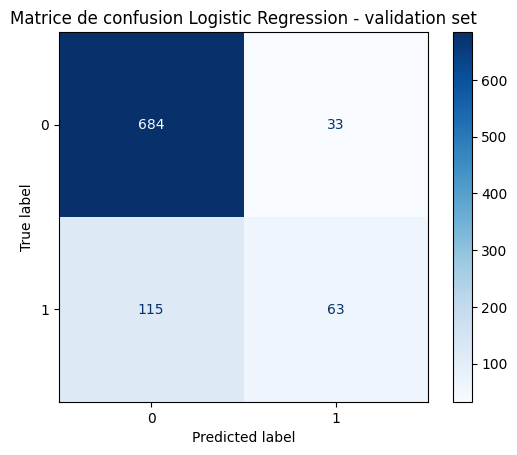

In [29]:
cm = confusion_matrix(y_valid, y_pred_valid)
 
# Affichage de la matrice
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion Logistic Regression - validation set")
plt.show()

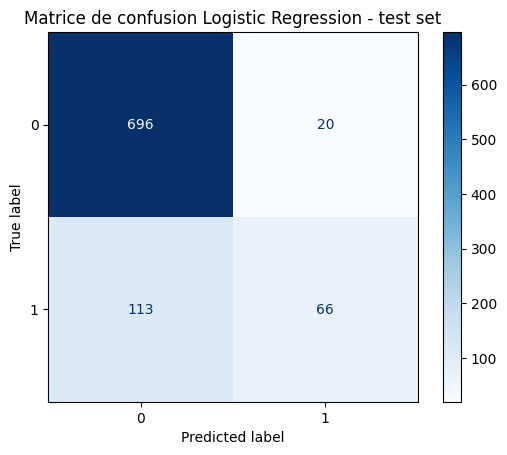

In [30]:
cm = confusion_matrix(y_test, y_pred_test)
 
# Affichage de la matrice
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion Logistic Regression - test set")
plt.show()

* #### Decision Tree

In [41]:
# Decision Tree
if _MODEL_TYPE == "Tree Based":
    print("Validation set Report:\n",classification_report(y_valid, y_pred_valid))
    print("------------------------------------------------------------------------")
    print("Test set Report:\n",classification_report(y_test, y_pred_test))

Validation set Report:
               precision    recall  f1-score   support

         0.0       0.91      0.96      0.94       717
         1.0       0.79      0.64      0.71       178

    accuracy                           0.89       895
   macro avg       0.85      0.80      0.82       895
weighted avg       0.89      0.89      0.89       895

------------------------------------------------------------------------
Test set Report:
               precision    recall  f1-score   support

         0.0       0.91      0.94      0.93       716
         1.0       0.74      0.64      0.69       179

    accuracy                           0.88       895
   macro avg       0.83      0.79      0.81       895
weighted avg       0.88      0.88      0.88       895



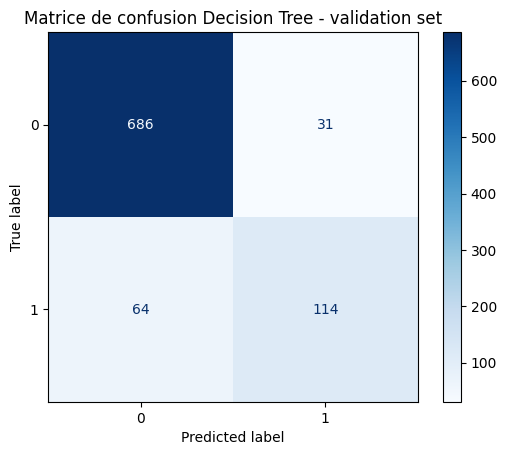

In [42]:
cm = confusion_matrix(y_valid, y_pred_valid)
 
# Affichage de la matrice
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion Decision Tree - validation set")
plt.show()

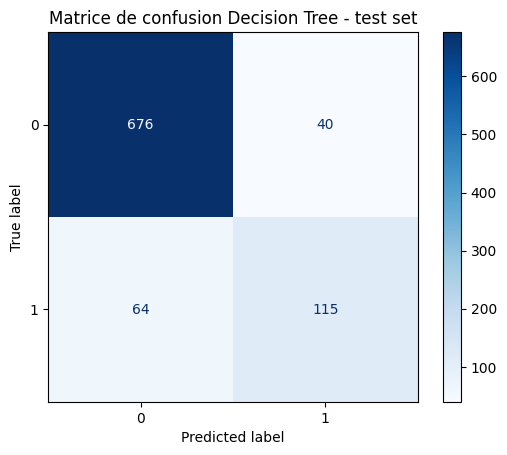

In [43]:
cm = confusion_matrix(y_test, y_pred_test)
 
# Affichage de la matrice
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion Decision Tree - test set")
plt.show()

* #### KNN

In [ ]:
# Rapport de classification
if _MODEL_TYPE == "KNN":
    print("Validation set Report:\n",classification_report(y_valid, y_pred_valid))
    print("------------------------------------------------------------------------")
    print("Test set Report:\n",classification_report(y_test, y_pred_test))

Validation set Report:
               precision    recall  f1-score   support

         0.0       0.89      1.00      0.94       717
         1.0       1.00      0.52      0.68       178

    accuracy                           0.90       895
   macro avg       0.95      0.76      0.81       895
weighted avg       0.91      0.90      0.89       895

------------------------------------------------------------------------
Test set Report:
               precision    recall  f1-score   support

         0.0       0.90      1.00      0.94       716
         1.0       0.97      0.55      0.70       179

    accuracy                           0.91       895
   macro avg       0.93      0.77      0.82       895
weighted avg       0.91      0.91      0.90       895



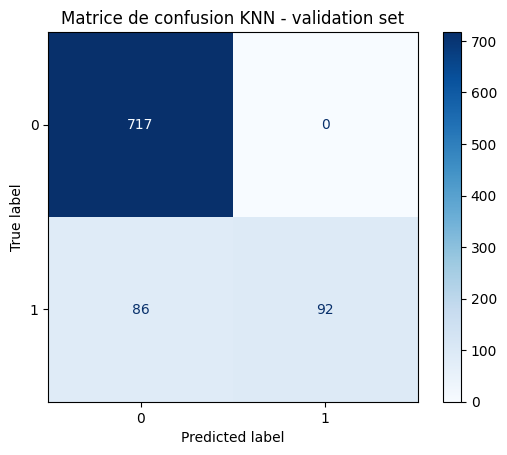

In [102]:
cm = confusion_matrix(y_valid, y_pred_valid)
 
# Affichage de la matrice
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion KNN - validation set")
plt.show()

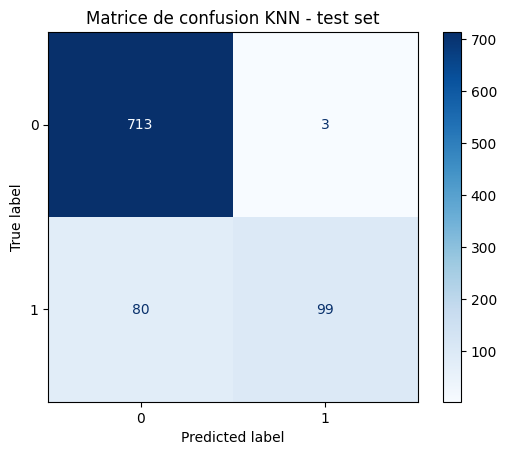

In [105]:
cm = confusion_matrix(y_test, y_pred_test)
 
# Affichage de la matrice
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion KNN - test set")
plt.show()

In [ ]:
# Suppression de l'endpoint
sagemaker_client = boto3.client('sagemaker', region_name=region)
sagemaker_client.delete_endpoint(EndpointName=sklearn_model.endpoint_name)